## Setup

In [1]:
!pip install http://download.pytorch.org/whl/cu75/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl  && pip install torchvision

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
    100% |████████████████████████████████| 397.4MB 44.8MB/s 
Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
    100% |████████████████████████████████| 61kB 3.8MB/s 
    100% |████████████████████████████████| 2.0MB 7.7MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [2]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
    100% |████████████████████████████████| 5.6MB 8.0MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.1.0
    Uninstalling Pillow-5.1.0:
      Successfully uninstalled Pillow-5.1.0
Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
    100% |████████████████████████████████| 7.1MB 4.3MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.


In [3]:
!pip install fastai

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
    100% |████████████████████████████████| 430kB 6.1MB/s 
    100% |████████████████████████████████| 1.3MB 10.5MB/s 
    100% |████████████████████████████████| 1.5MB 14.0MB/s 
    100% |████████████████████████████████| 112kB 19.4MB/s 
    100% |████████████████████████████████| 174kB 10.9MB/s 


    100% |████████████████████████████████| 20.9MB 2.0MB/s 
    100% |████████████████████████████████| 3.4MB 12.3MB/s 
    100% |████████████████████████████████| 112kB 24.6MB/s 
    100% |████████████████████████████████| 51kB 21.6MB/s 
    100% |████████████████████████████████| 51kB 17.8MB/s 
    100% |████████████████████████████████| 2.2MB 10.5MB/s 


    100% |████████████████████████████████| 4.2MB 8.1MB/s 
    100% |████████████████████████████████| 61kB 17.6MB/s 
    100% |████████████████████████████████| 552kB 21.6MB/s 
    100% |████████████████████████████████| 13.7MB 3.3MB/s 
    100% |████████████████████████████████| 92kB 21.9MB/s 
    100% |████████████████████████████████| 5.7MB 10.8MB/s 
    100% |████████████████████████████████| 471kB 12.2MB/s 
    100% |████████████████████████████████| 860kB 21.9MB/s 
    100% |████████████████████████████████| 81kB 20.0MB/s 


    100% |████████████████████████████████| 71kB 16.1MB/s 
  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 102kB 15.5MB/s 
    100% |████████████████████████████████| 61kB 19.5MB/s 
    100% |████████████████████████████████| 81kB 18.8MB/s 
  Running setup.py bdist_wheel for fastai ... - \ done
  Stored in directory: /content/.cache/pip/wheels/98/2b/88/fe4cfe5bfa9cfea91cdfd2fe205f88746bf103f7b2994dffba
  Running setup.py bdist_wheel for bcolz ... - \ | / - \ | /

 - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done
  Stored in directory: /content/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
  Running setup.py bdist_wheel for feather-format ... - done
  Stored in directory: /content/.cache/pip/wheels/85/7d/12/2dfa5c0195f921ac935f5e8f27deada74972edc0ae9988a9c1
  Running setup.py bdist_wheel for kaggle-cli ... - done
  Stored in directory: /content/.cache/pip/wheels/d5/bb/10/c1dd1b08c7433c943cb55c46367ae3f891415e8a37300ff8a7
  Running setup.py bdist_wheel for pandas-summary ... - done
  Stored in directory: /content/.cache/pip/wheels/86/a9/6b/36b727a9ec687dac08bd3d0501cddd7b1a223943513eb04a03
  Running setup.py bdist_wheel for torchtext ... - \ done
  Stored in directory: /content/.cache/pip/wheels/42/a6/f4/b267328bde6bb680094a0c173e8e56

In [4]:
!apt update && apt install -y libsm6 libxext6

Get:1 http://security.ubuntu.com/ubuntu artful-security InRelease [83.2 kB]
Hit:2 http://archive.ubuntu.com/ubuntu artful InRelease
Get:3 http://archive.ubuntu.com/ubuntu artful-updates InRelease [88.7 kB]
Get:4 http://security.ubuntu.com/ubuntu artful-security/main amd64 Packages [198 kB]
Get:5 http://archive.ubuntu.com/ubuntu artful-backports InRelease [74.6 kB]
Get:6 http://security.ubuntu.com/ubuntu artful-security/universe amd64 Packages [74.3 kB]
Get:7 http://archive.ubuntu.com/ubuntu artful-updates/main amd64 Packages [323 kB]
Get:8 http://archive.ubuntu.com/ubuntu artful-updates/universe amd64 Packages [136 kB]
Get:9 http://archive.ubuntu.com/ubuntu artful-backports/universe amd64 Packages [4,359 B]
Get:10 http://archive.ubuntu.com/ubuntu artful-backports/main amd64 Packages [1,462 B]
Fetched 983 kB in 1s (599 kB/s)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
4 packages can be upgraded. Run 'apt list --upgradable' to see them.

In [5]:
!pip install kaggle-cli

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
    100% |████████████████████████████████| 5.3MB 6.0MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.
  Found existing installation: lxml 4.2.1
    Uninstalling lxml-4.2.1:
      Successfully uninstalled lxml-4.2.1


### Download the dataset

In [6]:
!mkdir data && cd data && kg download -u samanyougarg -p RadhaKrishna100 -c digit-recognizer

downloading https://www.kaggle.com/c/digit-recognizer/download/train.csv

train.csv 100% |####################################| Time: 0:00:02  24.9 MiB/s

downloading https://www.kaggle.com/c/digit-recognizer/download/test.csv

test.csv 100% |#####################################| Time: 0:00:01  27.1 MiB/s

downloading https://www.kaggle.com/c/digit-recognizer/download/sample_submission.csv

sample_submission.csv 100% |#######################| Time: 0:00:00 1019.2 KiB/s



In [0]:
!cd data && mkdir train valid test

In [0]:
!cd data/train && mkdir 0 1 2 3 4 5 6 7 8 9
!cd data/valid && mkdir 0 1 2 3 4 5 6 7 8 9

### Imports

In [0]:
# Automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [0]:
# path of the data folder
PATH = "data/"
# image size
sz=28

## Data Exploration

In [12]:
# contents of our data folder
os.listdir(PATH)

['train.csv', 'test.csv', 'test', 'sample_submission.csv', 'train', 'valid']

In [13]:
# contents of our validation set
os.listdir(f'{PATH}valid')

['1', '0', '9', '4', '5', '3', '6', '8', '2', '7']

In [0]:
# Read the data from CSV
data_df = pd.read_csv(f'{PATH}train.csv', header = 0)

In [15]:
data_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
# Create a new dataframe with the label column from data_df
label_df = data_df['label']

In [0]:
del data_df['label']

In [0]:
# Get the pixel value from data_df into a numpy array with 42000 rows(no of images in train.csv) and 784 columns(28 X 28 images)
data_values = data_df.values

In [19]:
data_values.shape

(42000, 784)

In [0]:
for i in range(0, len(data_values)):

    #read the correct label
    correct_label = label_df[i]

    #split the data into training and validation sets
    if np.random.rand() < 0.8:
        folder = 'train/'
    else:
        folder = 'valid/'
    
    img = data_values[i][:]

    #reshape into 28x28 pic
    img = img.reshape(28,28)

    #we need three channels into the picture
    img = np.stack((img,)*3,axis = -1)

    #change the data type to int8
    img = np.uint8(img)

    #create PIL Image
    new_img = Image.fromarray(img)

    #save the .jpg into correct folder
    new_img.save(f'{PATH}' + folder + str(correct_label) + '/' + str(i) + '.jpg', 'JPEG')

In [0]:
# Read the test data from CSV
test_df = pd.read_csv(f'{PATH}test.csv', header = 0)

In [22]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
test_values = test_df.values

In [0]:
for i in range(0, len(test_values)):

    folder = 'test/'
    
    img = test_values[i][:]

    #reshape into 28x28 pic
    img = img.reshape(28,28)

    #we need three channels into the picture
    img = np.stack((img,)*3,axis = -1)

    #change the data type to int8
    img = np.uint8(img)

    #create PIL Image
    new_img = Image.fromarray(img)

    #save the .jpg into correct folder
    new_img.save(f'{PATH}' + folder + str(i) + '.jpg', 'JPEG')

In [25]:
# Grab the first 5 images for '0'
files = os.listdir(f'{PATH}valid/0')[:5]
files

['13829.jpg', '24118.jpg', '20178.jpg', '7140.jpg', '11964.jpg']

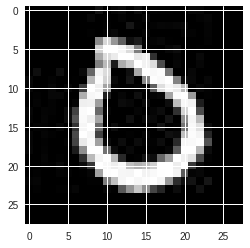

In [26]:
# Plot the first image from files list
img = plt.imread(f'{PATH}valid/0/{files[0]}')
plt.imshow(img);

**Image is a 3d array (Rank 3 tensor).**

The first two indices represent the Y and X positions of a pixel, and the third represents the RGB colour value of the pixel.

In [27]:
img.shape

(28, 28, 3)

We can crop the image by slicing the image array.

In [28]:
# Matrix representation of the sliced image array
img = img[:4,:4]; img

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

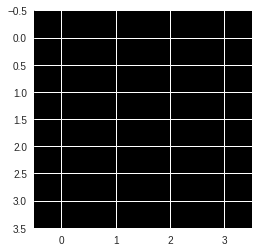

In [29]:
plt.imshow(img)

## Model

We're going to use a <b>pre-trained</b> model - <b>resnet34</b> trained on ImageNet (1.2 million images and 1000 classes). 
resnet34 is a version of the model that won the 2015 ImageNet competition.

**1. data contains the validation and training data**

**2. learn contains the model**

**3. The first two values in the output are the values of the loss function (in this case the cross-entropy loss) for the training set and the validation set. The last value in the output is the accuracy on the validation set.**

In [30]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=True)
# This will do 3 epochs which means it is going to look at the entire set of images three times.
learn.fit(0.01, 3)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /content/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 76066418.60it/s]


100%|██████████| 438/438 [00:21<00:00, 20.69it/s]


[0.      0.37827 0.24341 0.92304]
[1.      0.3236  0.21735 0.93374]
  2%|▏         | 10/525 [00:00<00:34, 14.85it/s, loss=0.327]

[2.      0.29621 0.19788 0.94039]



## Analysing the results

Labels for the validation set.

In [31]:
data.val_y

array([0, 0, 0, ..., 9, 9, 9])

So, **cats** have label **0** and **dogs** have label **1**.

In [32]:
data.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Predictions for the validation set in log scale.

In [33]:
log_preds = learn.predict()
log_preds.shape

(8424, 10)

In [34]:
log_preds[:10]

array([[ -0.00074, -11.74199,  -9.88672, -11.40453, -11.39766, -11.63973,  -7.58521,  -9.08901, -14.67485,
        -10.65759],
       [ -0.71225,  -7.08158,  -3.78145,  -4.25441,  -7.6168 ,  -5.39547,  -3.55699,  -7.2315 ,  -0.87319,
         -3.9255 ],
       [ -0.00004, -13.41707, -12.26753, -13.35298, -13.55263, -14.13158, -12.31509, -12.51908, -15.62729,
        -10.70406],
       [ -0.00037, -12.44038, -10.41855, -12.27578, -13.00914, -14.24418,  -8.08081, -13.543  , -11.47806,
        -11.74209],
       [ -0.00002, -12.98046, -14.63845, -14.84439, -13.62669, -14.95681, -12.99193, -11.68672, -17.24859,
        -12.05017],
       [ -0.00004, -12.7107 , -11.97548, -13.30078, -12.15084, -15.72725, -12.52234, -11.75533, -16.35875,
        -11.51342],
       [ -0.00059, -11.72324, -11.4599 , -10.64053, -11.20491, -13.12434, -10.76114,  -9.88126, -10.0708 ,
         -7.77746],
       [ -0.00053, -12.41544, -10.71639, -10.80305,  -9.86709, -10.5717 ,  -7.97096, -11.61702, -10.94601,
    

Use **np.argmax** to get the actual probabilities between 0 and 1 and **np.exp** to get the actual predictions.

In [0]:
preds = np.argmax(log_preds, axis=1)
# Gives the probablities for dogs
# : in log_preds means give all rows and 1 means give the second column
probs = np.exp(log_preds[:,1])

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [0]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

A few correct labels at random.

Correctly classified


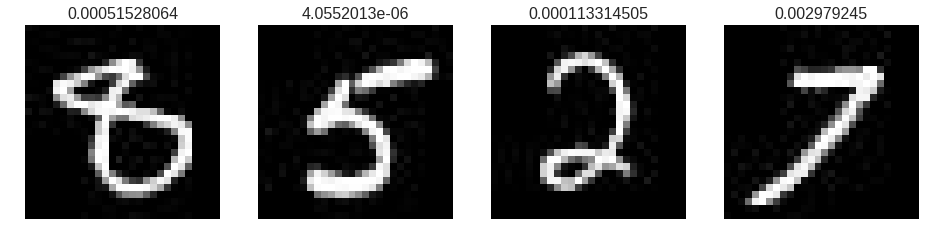

In [40]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

A few incorrect labels at random.

Incorrectly classified


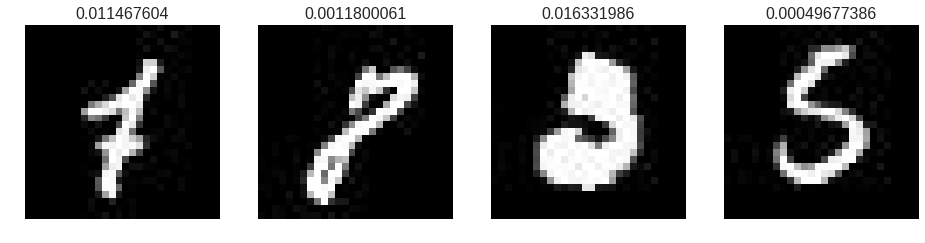

In [41]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct 0s


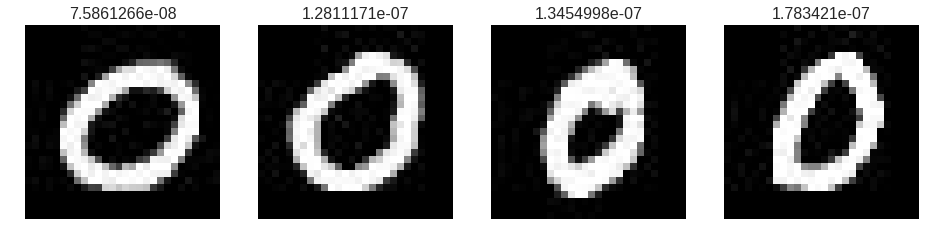

In [43]:
plot_val_with_title(most_by_correct(0, True), "Most correct 0s")

Most correct 1s


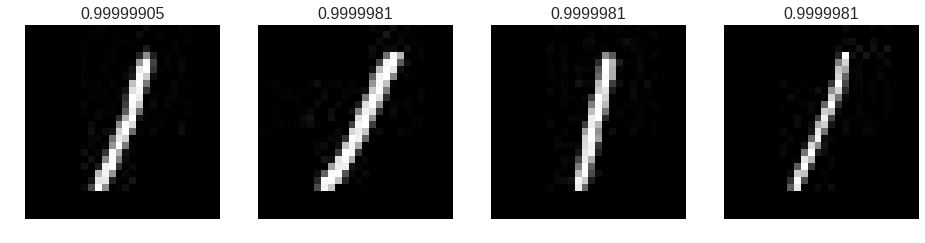

In [44]:
plot_val_with_title(most_by_correct(1, True), "Most correct 1s")

Most incorrect 0s


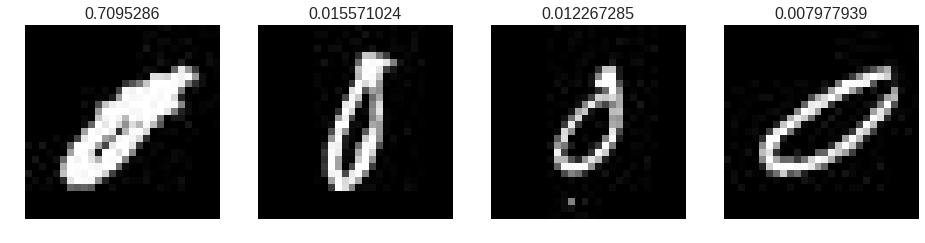

In [45]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect 0s")

Most incorrect 1s


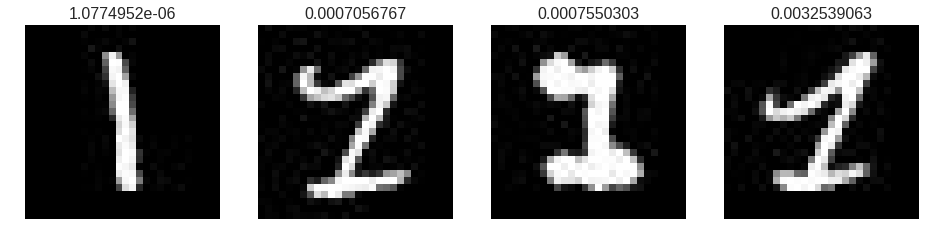

In [46]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect 1s")

## Find a suitable learning rate using the Learning Rate Finder.

In [0]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [48]:
lrf=learn.lr_find()

 83%|████████▎ | 436/525 [00:12<00:02, 34.30it/s, loss=3.06]

Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

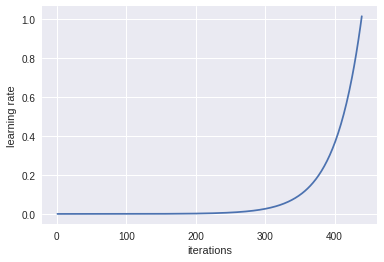

In [49]:
learn.sched.plot_lr()

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

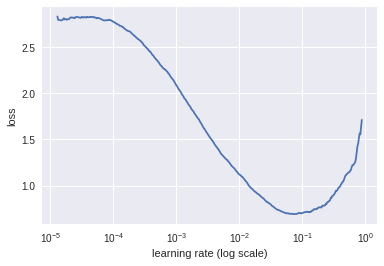

In [50]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use.

## Improving Model

In [0]:
learn.precompute=False

In [52]:
learn.fit(1e-2, 3, cycle_len=1)


  3%|▎         | 16/525 [00:03<02:03,  4.11it/s, loss=2.86]



[0.      0.41285 0.28614 0.91091]


[1.      0.33245 0.22536 0.92737]
[2.      0.31561 0.2018  0.93471]



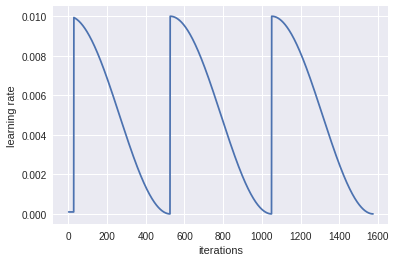

In [53]:
learn.sched.plot_lr()

In [0]:
learn.save('28_lastlayer')

In [0]:
learn.load('28_lastlayer')

### Fine-tuning and differential learning rate annealing

In [0]:
learn.unfreeze()

In [0]:
lr=np.array([1e-4,1e-3,1e-2])

In [58]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

[0.      0.15763 0.09374 0.97457]


[1.      0.09335 0.06539 0.9812 ]
[2.      0.05652 0.06    0.98317]
  4%|▍         | 22/525 [00:09<03:36,  2.32it/s, loss=0.0542]

[3.      0.05124 0.06175 0.98298]


[4.      0.03714 0.04988 0.987  ]
[5.      0.0208  0.04727 0.98783]
  4%|▍         | 22/525 [00:09<03:43,  2.25it/s, loss=0.0209]

[6.      0.02461 0.04725 0.98814]



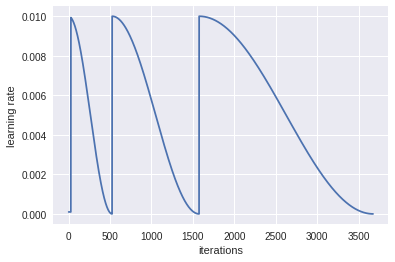

In [59]:
learn.sched.plot_lr()

In [0]:
learn.save('28_all')

In [0]:
learn.load('28_all')

In [62]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds, y), metrics.log_loss(y, probs)

(0.9882478632478633, 0.04696348772157545)

## Analysing the Results

### Confusion Matrix

In [0]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[869   0   0   0   0   0   2   0   1   1]
 [  0 937   1   1   0   0   0   2   0   1]
 [  0   3 766   1   2   0   1   2   2   1]
 [  0   0   1 853   0   4   0   0   3   5]
 [  0   1   0   0 816   0   1   0   0   5]
 [  0   0   0   3   0 750   2   0   4   2]
 [  0   2   0   0   0   1 804   0   1   0]
 [  0   1   2   0   5   1   0 888   0   1]
 [  0   0   1   1   2   5   1   1 801   5]
 [  0   0   0   1   4   0   0   8   4 841]]


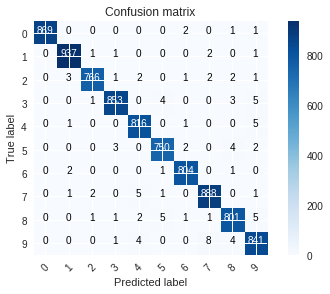

In [65]:
plot_confusion_matrix(cm, data.classes)

In [66]:
submission_csv = f'{PATH}sample_submission.csv'
submission_df = pd.read_csv(submission_csv)
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [67]:
data.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [68]:
data.test_ds.fnames

['test/18902.jpg',
 'test/11314.jpg',
 'test/27198.jpg',
 'test/643.jpg',
 'test/25624.jpg',
 'test/4111.jpg',
 'test/23327.jpg',
 'test/11796.jpg',
 'test/15388.jpg',
 'test/10125.jpg',
 'test/9321.jpg',
 'test/9188.jpg',
 'test/25803.jpg',
 'test/23189.jpg',
 'test/12562.jpg',
 'test/2049.jpg',
 'test/25383.jpg',
 'test/22154.jpg',
 'test/15170.jpg',
 'test/1285.jpg',
 'test/15574.jpg',
 'test/1404.jpg',
 'test/337.jpg',
 'test/19936.jpg',
 'test/11572.jpg',
 'test/7542.jpg',
 'test/2035.jpg',
 'test/13829.jpg',
 'test/6041.jpg',
 'test/22814.jpg',
 'test/1508.jpg',
 'test/24825.jpg',
 'test/1665.jpg',
 'test/24972.jpg',
 'test/1338.jpg',
 'test/5301.jpg',
 'test/10814.jpg',
 'test/15248.jpg',
 'test/12631.jpg',
 'test/4516.jpg',
 'test/12450.jpg',
 'test/13793.jpg',
 'test/18843.jpg',
 'test/2600.jpg',
 'test/25457.jpg',
 'test/26208.jpg',
 'test/1837.jpg',
 'test/15995.jpg',
 'test/16973.jpg',
 'test/5682.jpg',
 'test/24470.jpg',
 'test/7105.jpg',
 'test/16907.jpg',
 'test/10442.jp

In [69]:
# Get predictions on the test set
# (We can't get accuracy since by definition we don't know)
log_preds, y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds), 0)

In [70]:
submission_csv = f'{PATH}sample_submission.csv'
submission_df = pd.read_csv(submission_csv)
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [0]:
submission_df.insert(0,'filename',[o[5:] for o in data.test_ds.fnames])

In [72]:
submission_df.head()

,filename,ImageId,Label
0,18902.jpg,1,0
1,11314.jpg,2,0
2,27198.jpg,3,0
3,643.jpg,4,0
4,25624.jpg,5,0


In [0]:
del submission_df['filename']

In [0]:
Submission=f'{PATH}'
submission_df.to_csv(f'{Submission}submission.csv', index=False)

In [0]:
from google.colab import files
files.download(f'{Submission}submission.csv')